In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from scipy.stats import shapiro, kstest



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [5]:
df = pd.read_csv('../files/hr_raw_data_v2.csv')

In [6]:
df.head()

,employee_number,gender,birth_year,age,marital_status,dist_home,job_title,department,departured,year_at_comp,standard_hours,remote,business_travel,over_time,job_level,stock_opt_level,traning_times_last_year,perf_rate,year_last_promotion,year_current_mngr,education_field,education_scale,annual_salary,monthly_income,daily_rate,perc_salary_hike,env_sat_rate,job_involvement,job_sat_rate,relationship_sat_rate,work_life_balance,num_comp_worked,tot_working_year
0,1,M,1972,51.0,Unknown,6,Research Director,Research & Development,No,20,Full Time,Yes,Unknown,No,5,0,5,3.0,15,15,Unknown,3,195370.00,16280.830000,2015.722222,13,1,3,3,3,3.0,7,NaN
1,2,M,1971,52.0,Unknown,1,Manager,Unknown,No,33,NaN,Yes,Unknown,Unknown,5,1,5,3.0,11,9,Life Sciences,4,199990.00,16125.406667,2063.388889,14,3,2,3,1,3.0,0,34.0
2,3,M,1981,42.0,Married,4,Manager,Research & Development,No,22,NaN,Yes,travel_rarely,No,5,0,3,3.0,11,15,Technical Degree,2,192320.00,15943.720000,1984.253968,11,3,3,4,4,NaN,1,22.0
3,4,F,1976,47.0,Married,2,Research Director,Research & Development,No,20,Full Time,No,travel_rarely,Unknown,4,2,2,3.0,5,6,Medical,4,171690.00,14307.500000,1771.404762,19,1,3,3,2,NaN,3,NaN
4,5,F,1977,46.0,Divorced,3,Sales Executive,Sales,No,19,NaN,No,Unknown,No,4,1,5,3.0,2,8,Technical Degree,3,153407.07,12783.920000,1582.771346,12,1,4,1,4,3.0,2,NaN


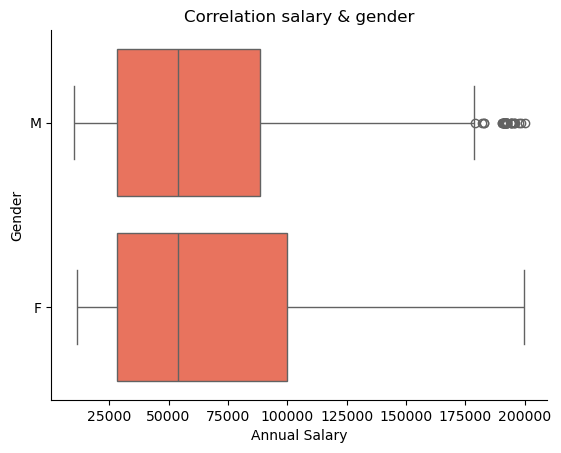

In [7]:
sns.boxplot(data=df, y='gender', x='annual_salary', color = 'tomato')
plt.title('Correlation salary & gender')
plt.xlabel('Annual Salary')
plt.ylabel('Gender')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: El rango salarial de las mujeres es un poco mayor que el de los hombres, aunque solo hay outliers en los salarios de los hombres. La mediana es igual es ambos géneros.

In [8]:
df['standard_hours'].mode()

0    Part Time
Name: standard_hours, dtype: object

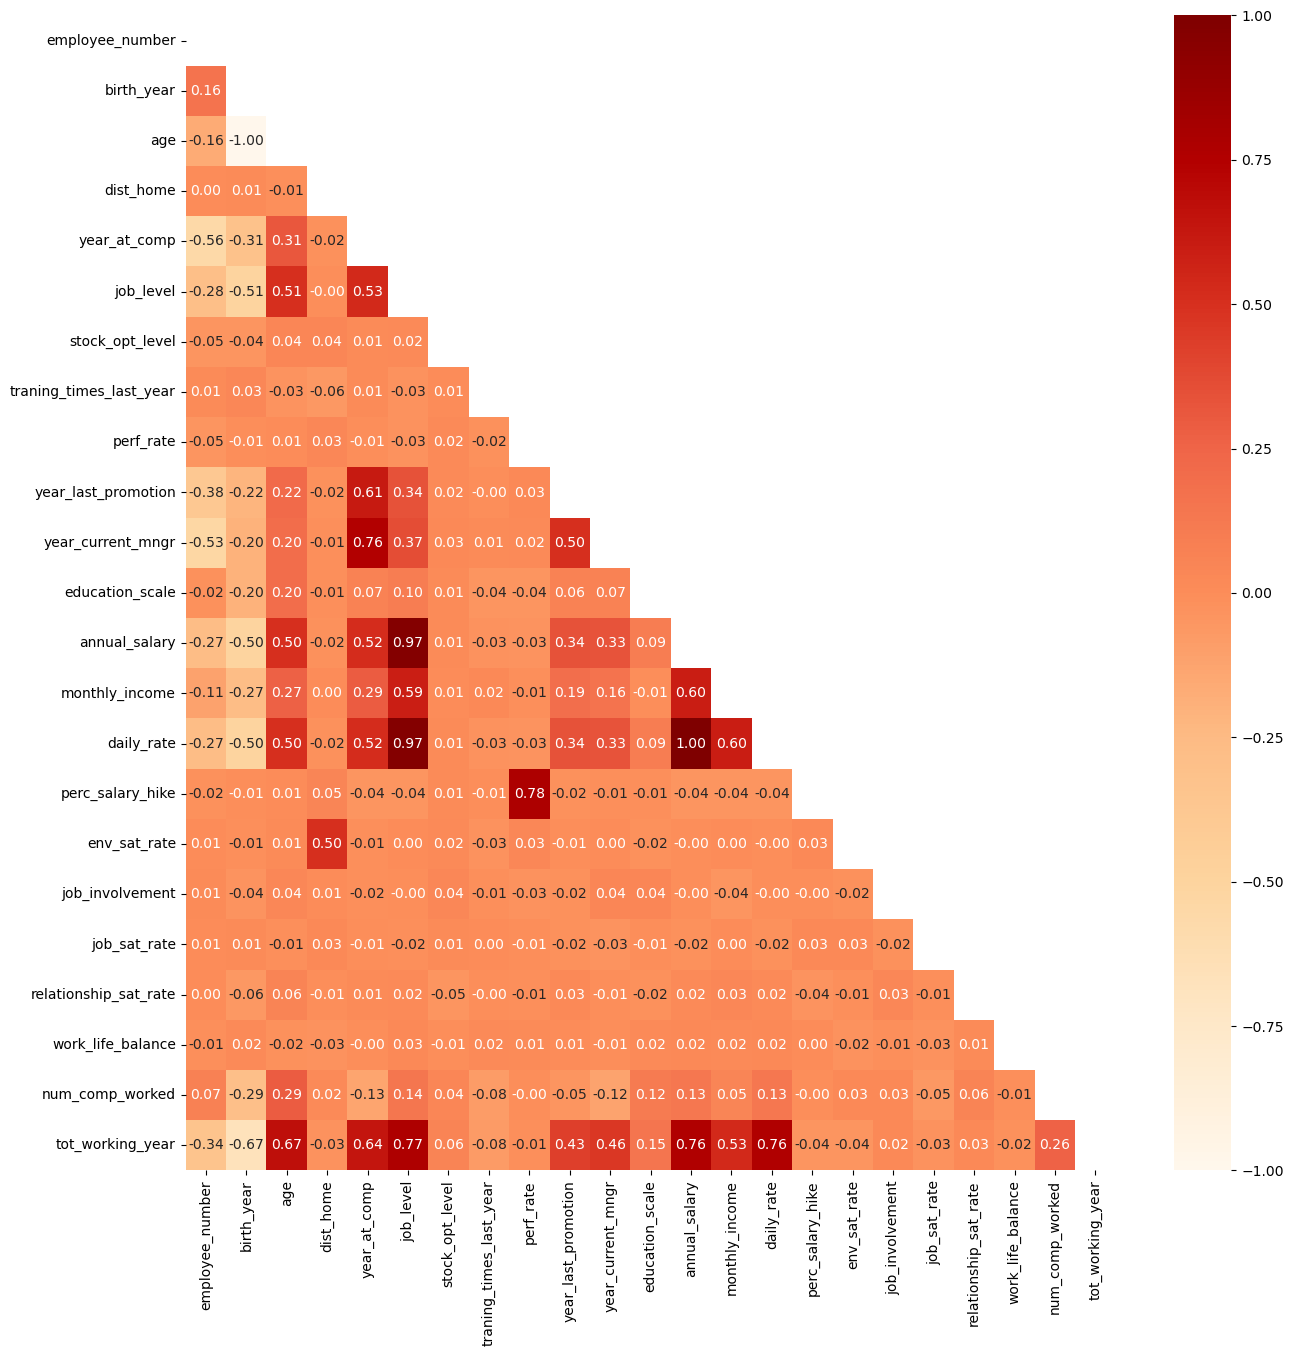

In [9]:
# GENERAL DATA ANALYSIS

numerics = df.select_dtypes(exclude = 'O').columns
df_corr = df[numerics].corr(method = 'pearson')


plt.figure(figsize = (15, 15))

mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(df_corr, 
            annot = True, 
            fmt = ".2f", 
            cmap = "OrRd", 
            vmax = 1, 
            vmin = -1, 
            mask = mask); 

In [10]:
df.isnull().sum() / df.shape[0] * 100

employee_number             0.000000
gender                      0.000000
birth_year                  0.000000
age                         0.000000
marital_status              0.000000
dist_home                   0.000000
job_title                   0.000000
department                  0.000000
departured                  0.000000
year_at_comp                0.000000
standard_hours             20.941760
remote                      0.000000
business_travel             0.000000
over_time                   0.000000
job_level                   0.000000
stock_opt_level             0.000000
traning_times_last_year     0.000000
perf_rate                  12.081784
year_last_promotion         0.000000
year_current_mngr           0.000000
education_field             0.000000
education_scale             0.000000
annual_salary               0.000000
monthly_income              0.000000
daily_rate                  0.000000
perc_salary_hike            0.000000
env_sat_rate                0.000000
j

In [11]:
df_estadisticos_cat = df.select_dtypes(include = 'O').describe().T

In [12]:
df_estadisticos_cat['freq%'] = df_estadisticos_cat['freq'].values/df.shape[0]*100

In [13]:
df_estadisticos_cat

,count,unique,top,freq,freq%
gender,1614,2,M,971,60.16109
marital_status,1614,4,Unknown,651,40.334572
job_title,1614,9,Sales Executive,369,22.862454
department,1614,4,Research & Development,1001,62.019827
departured,1614,2,No,1355,83.952912
standard_hours,1276,2,Part Time,888,55.018587
remote,1614,2,Yes,1000,61.957869
business_travel,1614,4,Unknown,772,47.831475
over_time,1614,3,No,682,42.255266
education_field,1614,7,Unknown,745,46.158612


In [14]:
df['salary_scale'] = pd.cut(df['annual_salary'],bins = 3, labels= ['Low', 'Medium', 'High']) 

In [15]:
# filtramos los datos para obtener los grupos. Estos grupos van a ser series de datos
grupo_research = df[df['department'] == 'Research & Development'] [['annual_salary','standard_hours', 'salary_scale']]
grupo_unknown = df[df['department'] == 'Unknown'] [['annual_salary','standard_hours', 'salary_scale']]
grupo_sales = df[df['department'] == 'Sales'] [['annual_salary','standard_hours', 'salary_scale']]
grupo_hhrr = df[df['department'] == 'Human Resources'] [['annual_salary','standard_hours', 'salary_scale']]

In [16]:
lista = ['Research & Development', 'Unknown', 'Sales', 'Human Resources']

In [17]:
lista1 = ['Part Time', 'Full Time']

In [18]:
df_grupo_research = pd.DataFrame(grupo_research)
df_grupo_unknown = pd.DataFrame(grupo_unknown)
df_grupo_sales = pd.DataFrame(grupo_sales)
df_grupo_hhrr = pd.DataFrame(grupo_hhrr)

In [19]:
#imprimimos las estadísticas:
for filtro in lista:
    print(filtro)
    display(df[df['department'] == filtro]['annual_salary'].describe().round(2).reset_index().T)
    print('-' * 40)

Research & Development


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,1001.0,58413.92,43038.92,10090.0,28111.13,44220.0,64720.0,199730.0


----------------------------------------
Unknown


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,91.0,167680.14,27964.12,100071.84,153407.07,170990.0,191324.62,199990.0


----------------------------------------
Sales


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,464.0,61231.4,28763.74,10520.0,48387.5,53914.11,69690.0,187890.0


----------------------------------------
Human Resources


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,58.0,45159.34,27708.86,20640.0,28111.13,28111.13,53914.11,153407.07


----------------------------------------


''

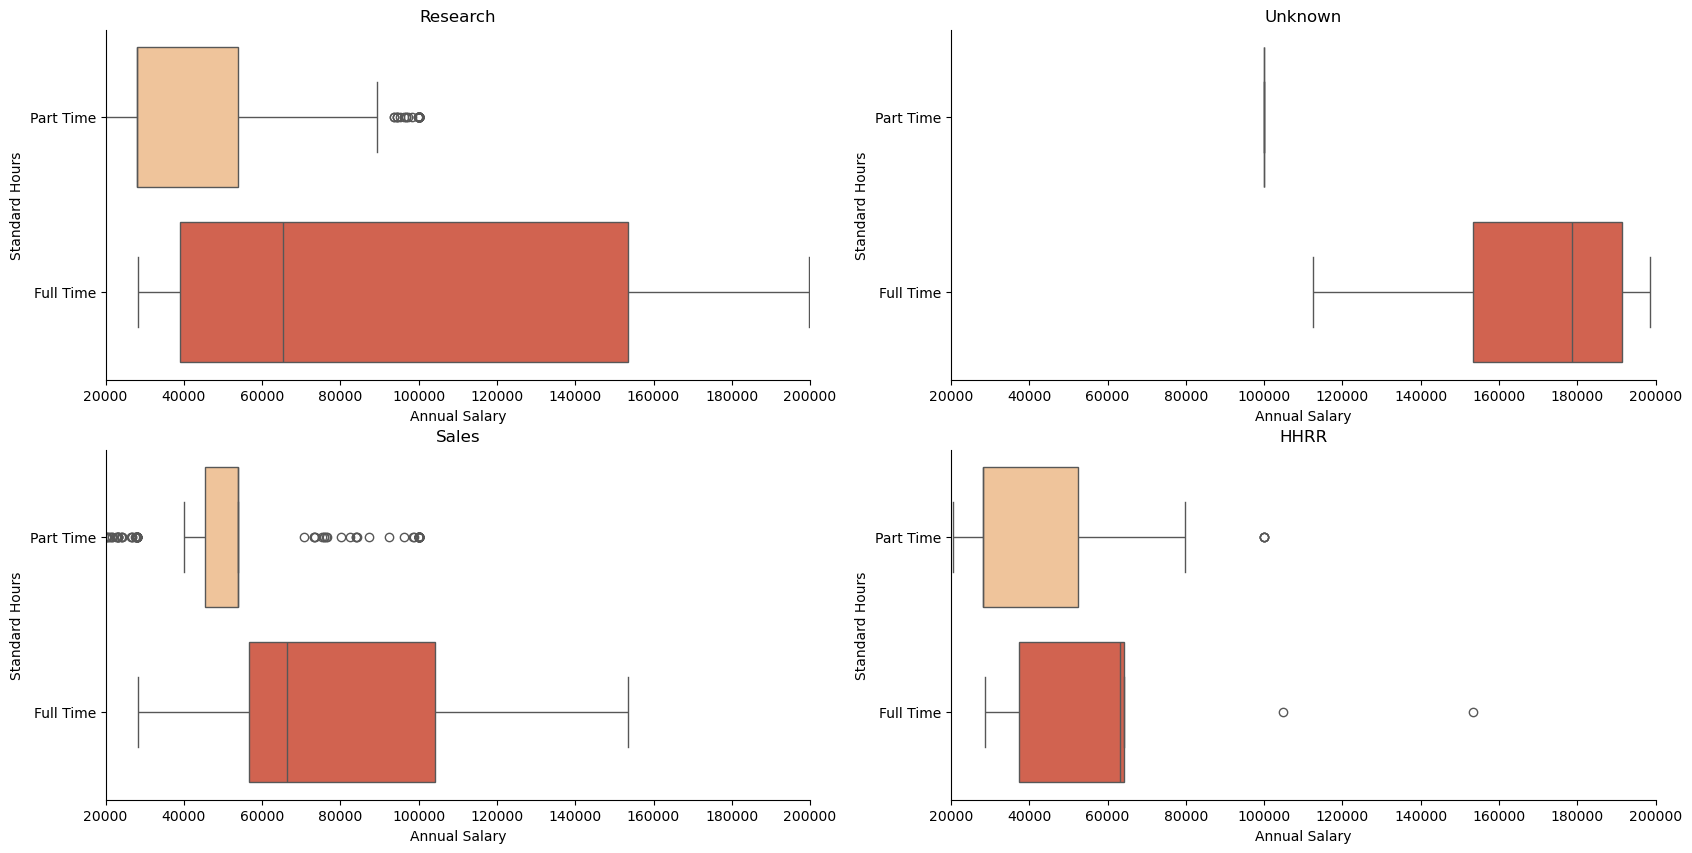

In [20]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))
sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_research,
            palette = "OrRd",
            ax = axes[0,0])
axes[0,0].set_title("Research")
axes[0,0].set_xlabel("Annual Salary")
axes[0,0].set_ylabel("Standard Hours")
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)

sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_unknown,
            palette = "OrRd",
            ax = axes[0,1])
axes[0,1].set_title("Unknown")
axes[0,1].set_xlabel("Annual Salary")
axes[0,1].set_ylabel("Standard Hours")
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)

sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_sales,
            palette = "OrRd",
            ax = axes[1,0])
axes[1,0].set_title("Sales")
axes[1,0].set_xlabel("Annual Salary")
axes[1,0].set_ylabel("Standard Hours")
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)

sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_hhrr,
            palette = "OrRd",
            ax = axes[1,1])
axes[1,1].set_title("HHRR")
axes[1,1].set_xlabel("Annual Salary")
axes[1,1].set_ylabel("Standard Hours")
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)

#ponemos la misma escala en los ejes:
#eje x:
axes[0,0].set_xlim(20000,200000) 
axes[0,1].set_xlim(20000,200000) 
axes[1,0].set_xlim(20000,200000) 
axes[1,1].set_xlim(20000,200000);
;

Interpretación: Este gráfico compara los salarios anuales y los tipos de jornada (jornada completa y media jornada) en los diferentes departamentos (Research, Sales, HRRR y Unknown). 
Además, hay variaciones significativas entre departamentos, destacando Research con los salarios más altos y un mayor número de outilers en los empleados de media jornada, junto con Sales.

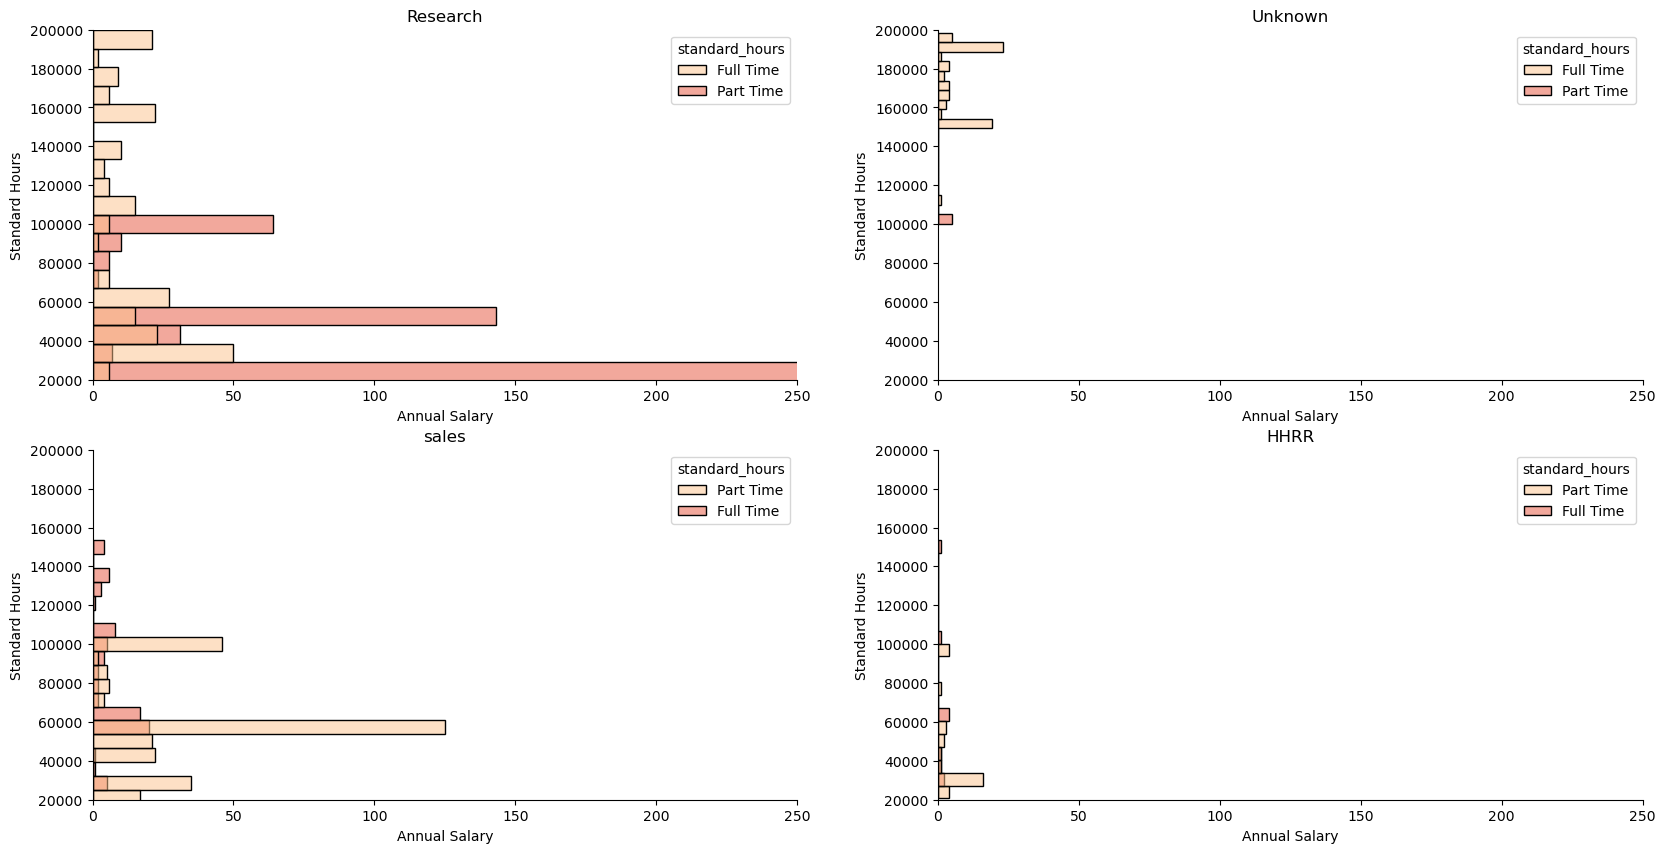

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

sns.histplot(y = "annual_salary",
            hue = "standard_hours", 
            data = df_grupo_research, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[0,0])
axes[0,0].set_title("Research")
axes[0,0].set_xlabel("Annual Salary")
axes[0,0].set_ylabel("Standard Hours")
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)

sns.histplot(y = "annual_salary",
            hue = "standard_hours",  
            data = df_grupo_unknown, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[0,1])
axes[0,1].set_title("Unknown")
axes[0,1].set_xlabel("Annual Salary")
axes[0,1].set_ylabel("Standard Hours")
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)

sns.histplot(y = "annual_salary",
            hue = "standard_hours",  
            data = df_grupo_sales, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[1,0])
axes[1,0].set_title("sales")
axes[1,0].set_xlabel("Annual Salary")
axes[1,0].set_ylabel("Standard Hours")
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)

sns.histplot(y = "annual_salary",
            hue = "standard_hours",  
            data = df_grupo_hhrr, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[1,1])
axes[1,1].set_title("HHRR")
axes[1,1].set_xlabel("Annual Salary")
axes[1,1].set_ylabel("Standard Hours")
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)

#ponemos la misma escala en los ejes:
#eje x,:
axes[0,0].set_xlim(0,250) 
axes[0,1].set_xlim(0,250) 
axes[1,0].set_xlim(0,250) 
axes[1,1].set_xlim(0,250) 

#eje y, hasta 120.000:
axes[0,0].set_ylim(20000,200000) 
axes[0,1].set_ylim(20000,200000) 
axes[1,0].set_ylim(20000,200000) 
axes[1,1].set_ylim(20000,200000);

Este gráfico lo hemos utilizado para apoyar visualmente la interpretación de la gráfica anterior.

In [22]:
df['job_level'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

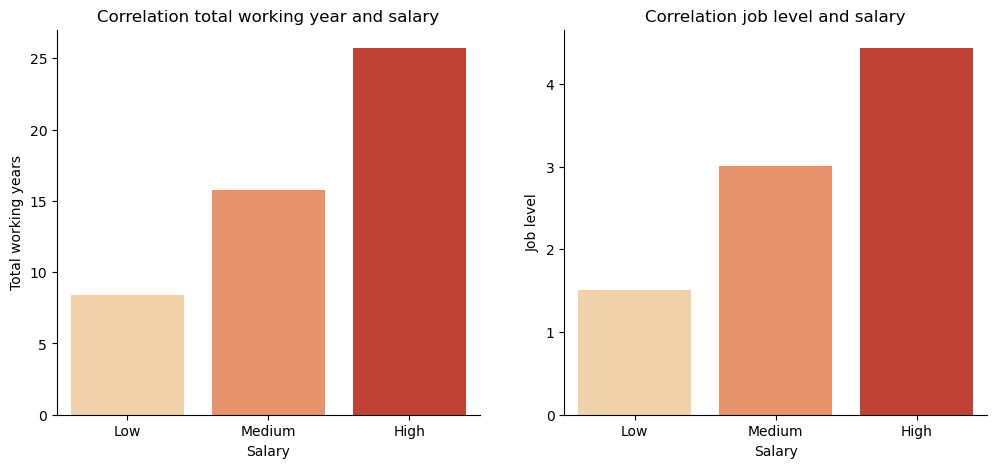

In [23]:
df['salary_scale'] = pd.cut(df['annual_salary'],bins = 3, labels= ['Low', 'Medium', 'High']) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

sns.barplot(data=df, y='tot_working_year', 
            x='salary_scale',
            palette='OrRd',
            ci=False,
            ax=axes[0])
axes[0].set_title("Correlation total working year and salary")
axes[0].set_xlabel("Salary")
axes[0].set_ylabel("Total working years")
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

sns.barplot(data=df, y='job_level', 
            x='salary_scale',
            palette='OrRd',
            ci=False)
axes[1].set_title("Correlation job level and salary")
axes[1].set_ylabel("Job level")
axes[1].set_xlabel("Salary")
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
plt.show();


Interpretación: Como es de esperar los trabajadores con mayor antigüedad y una mayor categoría laboral tienen un salario mayor.

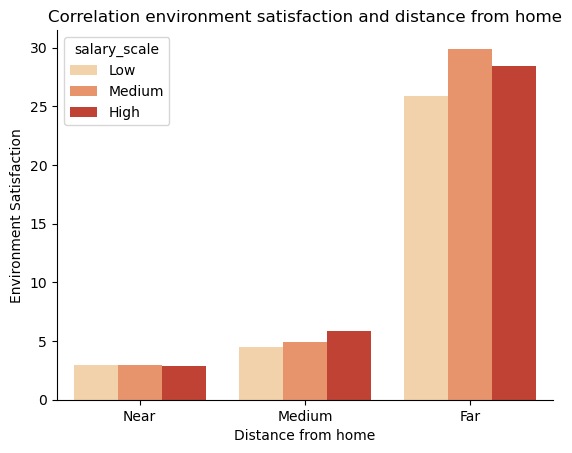

In [24]:
df['dist_home_scale'] = pd.cut(df['dist_home'],bins = 3, labels= ['Near', 'Medium', 'Far']) 


sns.barplot(data=df, y='env_sat_rate', 
            x='dist_home_scale',
            palette= 'OrRd',
            hue= 'salary_scale',
            ci=False)

plt.title("Correlation environment satisfaction and distance from home")
plt.ylabel("Environment Satisfaction")
plt.xlabel("Distance from home")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);


Interpretación: Se aprecia una clara relación entre una mayor distancia del trabajo y una mayor satisfacción.
Este dato nos ha sorprendido, por lo que hemos decidido entrar a analizar en mayor profundidad otras variables que pueden influir en el grado de satisfacción de las personas que viven más lejos del trabajo.

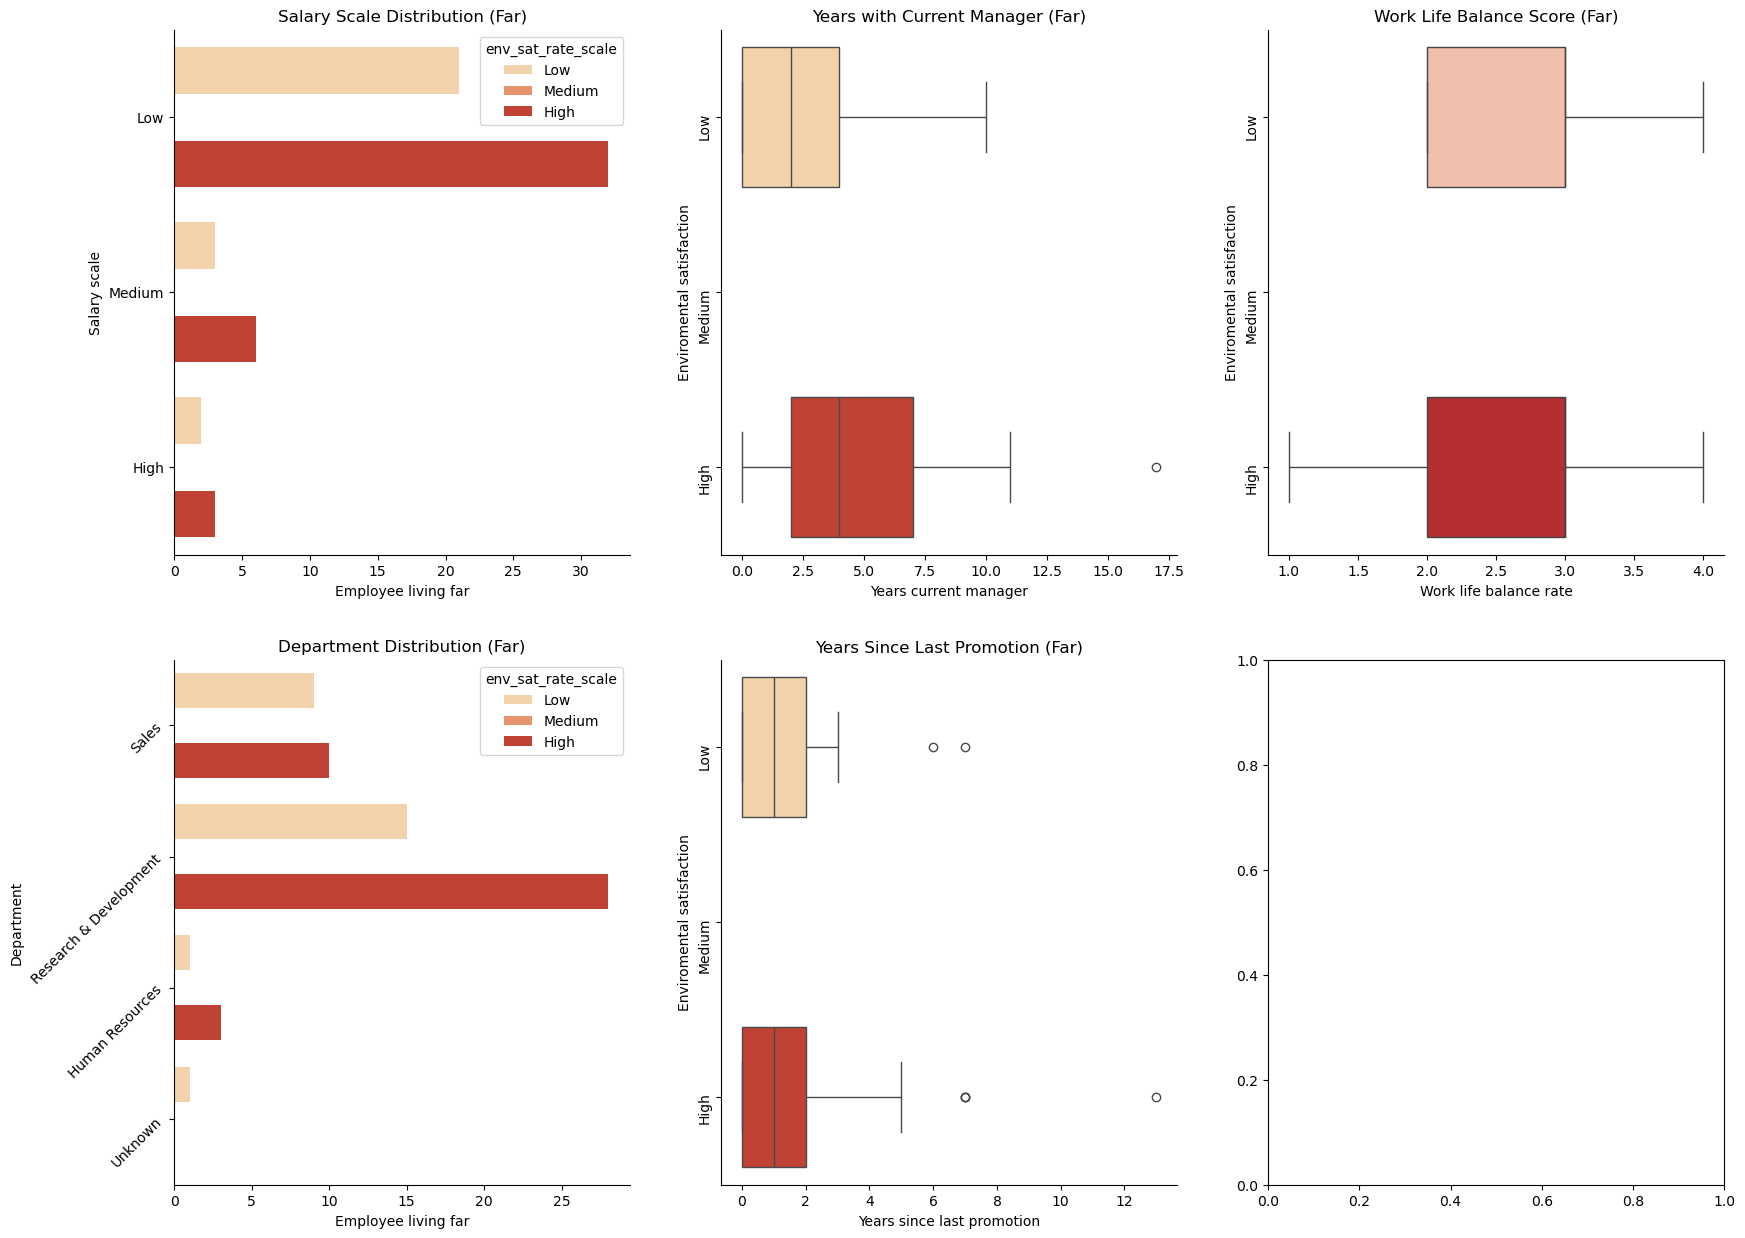

In [25]:
df['env_sat_rate_scale'] = pd.cut(df['env_sat_rate'],bins = 3, labels= ['Low', 'Medium', 'High'])
far_df = df[df['dist_home_scale'] == 'Far']
fig, axes = plt.subplots(2, 3, figsize=(20, 15)) 

sns.countplot(data=far_df,
              y='salary_scale',
              hue='env_sat_rate_scale',
              ax=axes[0,0],
              palette='OrRd')
axes[0,0].set_title('Salary Scale Distribution (Far)')
axes[0,0].set_xlabel('Employee living far')
axes[0,0].set_ylabel('Salary scale')
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)


sns.countplot(data=far_df,
              y='department',
              hue='env_sat_rate_scale',
              ax=axes[1,0],
              palette='OrRd')
axes[1,0].set_title('Department Distribution (Far)')
axes[1,0].tick_params(axis='y', rotation=45)
axes[1,0].set_xlabel('Employee living far')
axes[1,0].set_ylabel('Department')
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)


sns.boxplot(data=far_df,
            x='year_current_mngr',
            ax=axes[0,1],
            y='env_sat_rate_scale',
            palette='OrRd')
axes[0,1].set_title('Years with Current Manager (Far)')
axes[0,1].tick_params(axis='y', rotation=45)
axes[0,1].set_xlabel('Years current manager')
axes[0,1].set_ylabel('Enviromental satisfaction')
axes[0,1].tick_params(axis='y', rotation=90)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)


sns.boxplot(data=far_df, x='year_last_promotion',
            y='env_sat_rate_scale',
            ax=axes[1,1],
            palette='OrRd')
axes[1,1].set_title('Years Since Last Promotion (Far)')
axes[1,1].tick_params(axis='y', rotation=90)
axes[1,1].set_ylabel('Enviromental satisfaction')
axes[1,1].set_xlabel('Years since last promotion')
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)


sns.boxplot(data=far_df, x='work_life_balance',
            y='env_sat_rate_scale',
            ax=axes[0,2],
            palette='Reds')
axes[0,2].set_title('Work Life Balance Score (Far)')
axes[0,2].set_ylabel('Enviromental satisfaction')
axes[0,2].tick_params(axis='y', rotation=90)
axes[0,2].set_xlabel('Work life balance rate')
axes[0,2].spines['right'].set_visible(False)
axes[0,2].spines['top'].set_visible(False)
plt.show();

Interpretación: La imagen muestra el análisis del grado de satisfacción de los trabajadores (bajo, medio, alto) según factores laborales: salario, años con el mismo jefe, conciliación laboral, departamento y años desde la última promoción.
Los empleados con alta satisfacción predominan en Research and Development, y tienen una mejor conciliación laboral respecto a los demás departamentos. Además, los salarios bajos son más comunes entre quienes viven lejos.

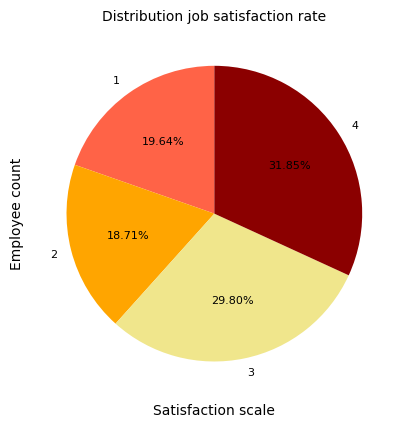

In [26]:
df_satisfaction_rate = df.groupby('job_sat_rate')['employee_number'].count().reset_index()
plt.pie('employee_number', labels = 'job_sat_rate', data=df_satisfaction_rate, autopct = '%1.2f%%', colors=['tomato', 'orange', 'khaki', 'darkred'], startangle=90, textprops={'fontsize': 8});
# Títulos y etiquetas
plt.title('Distribution job satisfaction rate', fontsize=10)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count');

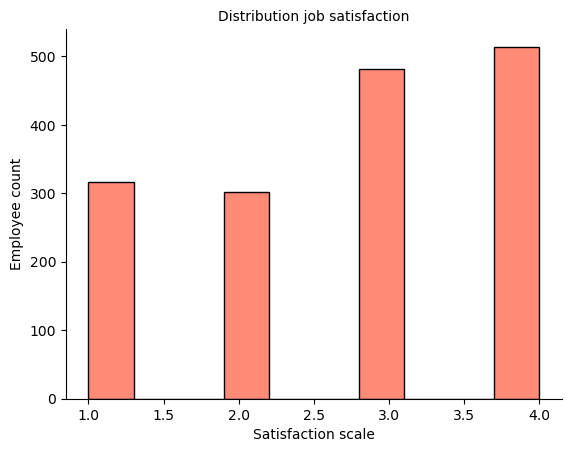

In [27]:
sns.histplot(data=df, x='job_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution job satisfaction', fontsize = 10)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: La satisfacción en el trabajo en términos generales es positva, ya que más de la mitad de los trabajadores marcan un nivel de satisfacción alto (60%), aunque el número de empleados con una satisfacción baja es bastante elevado (40%).

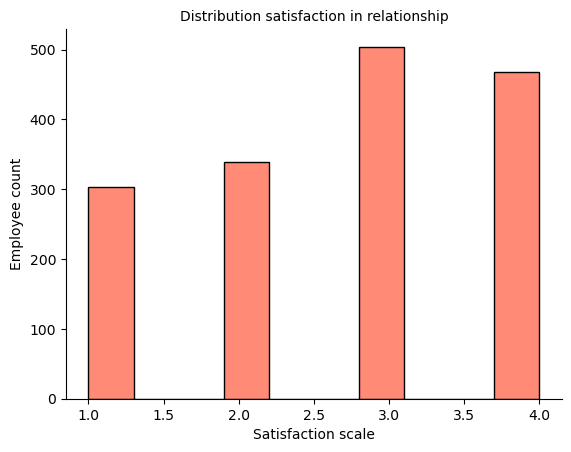

In [28]:
sns.histplot(data=df, x='relationship_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution satisfaction in relationship', fontsize = 10)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: Hay empleados en todos los niveles de satisfacción, aunque la curva muestra un aumento en los niveles más altos. Por lo que podemos concluir que la satisfacción general es positiva.

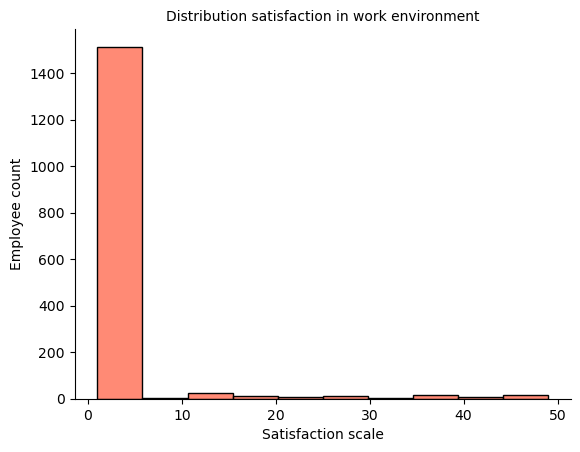

In [29]:
sns.histplot(data=df, x='env_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution satisfaction in work environment', fontsize = 10)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: La mayoría de los empleados (más de 1400) reportan niveles muy bajos de satisfacción con su entorno laboral. La gráfica está fuertemente sesgada hacia la izquierda, con muy pocos empleados distribuidos en niveles medios y altos de satisfacción.

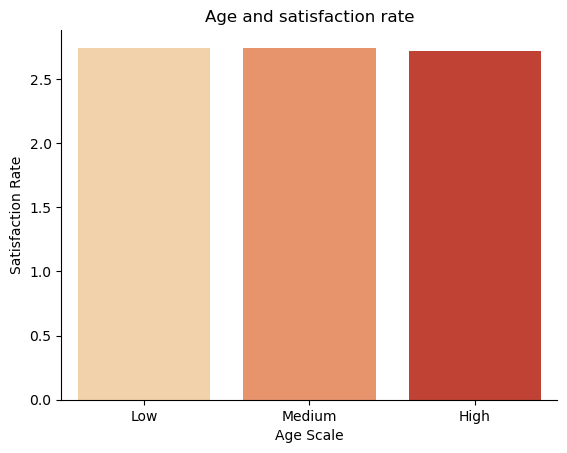

In [30]:
df['age_scale'] = pd.cut(df['age'],bins = 3, labels= ['Low', 'Medium', 'High'])
sns.barplot(data=df, y='job_sat_rate',
            x='age_scale',
            palette= 'OrRd',
            ci=False)
plt.title("Age and satisfaction rate")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Age Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: no hay una relación entre la edad y la satisfacción.

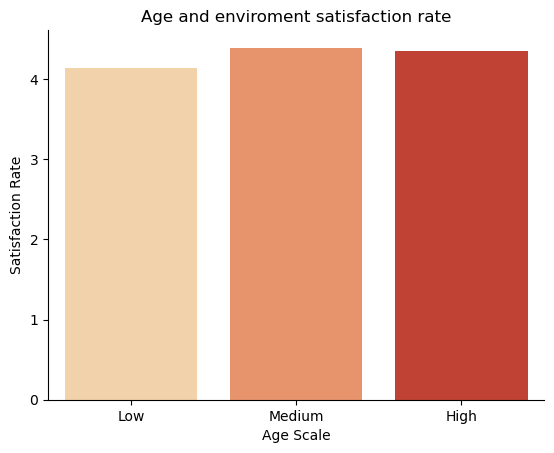

In [31]:
df['age_scale'] = pd.cut(df['age'],bins = 3, labels= ['Low', 'Medium', 'High'])
sns.barplot(data=df, y='env_sat_rate',
            x='age_scale',
            palette= 'OrRd',
            ci=False)
plt.title("Age and enviroment satisfaction rate")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Age Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: no hay una relación entre la edad y la satisfacción.

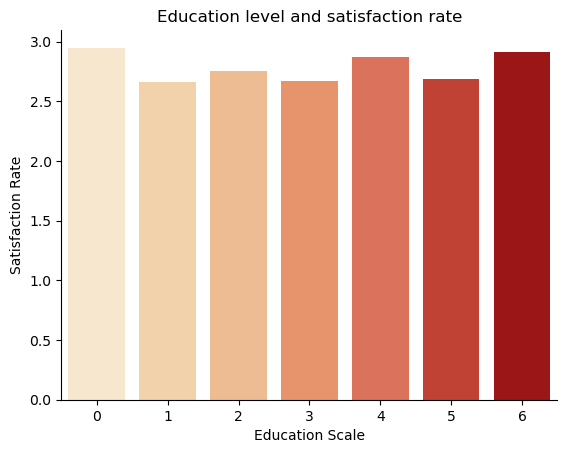

In [32]:
df['age_scale'] = pd.cut(df['age'],bins = 3, labels= ['Low', 'Medium', 'High'])
sns.barplot(data=df, y='job_sat_rate',
            x='traning_times_last_year',
            palette= 'OrRd',
            ci=False)
plt.title("Education level and satisfaction rate")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Education Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: no hay una relación entre el nivel educativo y la satisfacción.

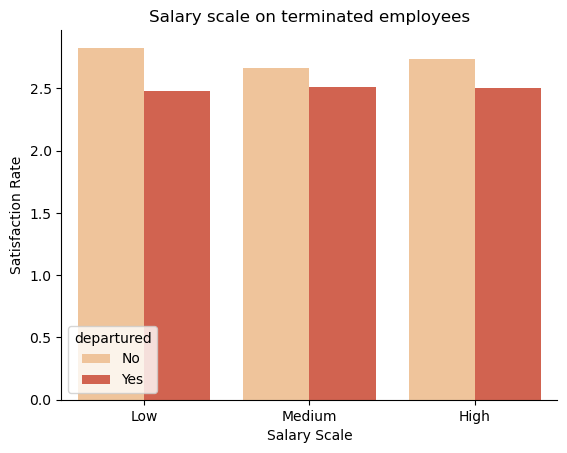

In [33]:
sns.barplot(data=df, y='job_sat_rate',
            x='salary_scale',
            hue='departured',
            palette= 'OrRd',
            ci=False)
plt.title("Salary scale on terminated employees")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Salary Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Interpretación: no hay una relación entre el rango salarial y la satisfacción, ni una diferencia significativa entre los han sido despedidos y los que continúan en la empresa.

In [34]:
df_count_departured = df.groupby('departured')['employee_number'].count().reset_index()

In [35]:
df['current_mngr'] = pd.cut(df['year_current_mngr'],bins = 4, labels= ['0-5', '6-10', '11-15', '16-20'])
yes_df = df[df['departured'] == 'Yes']


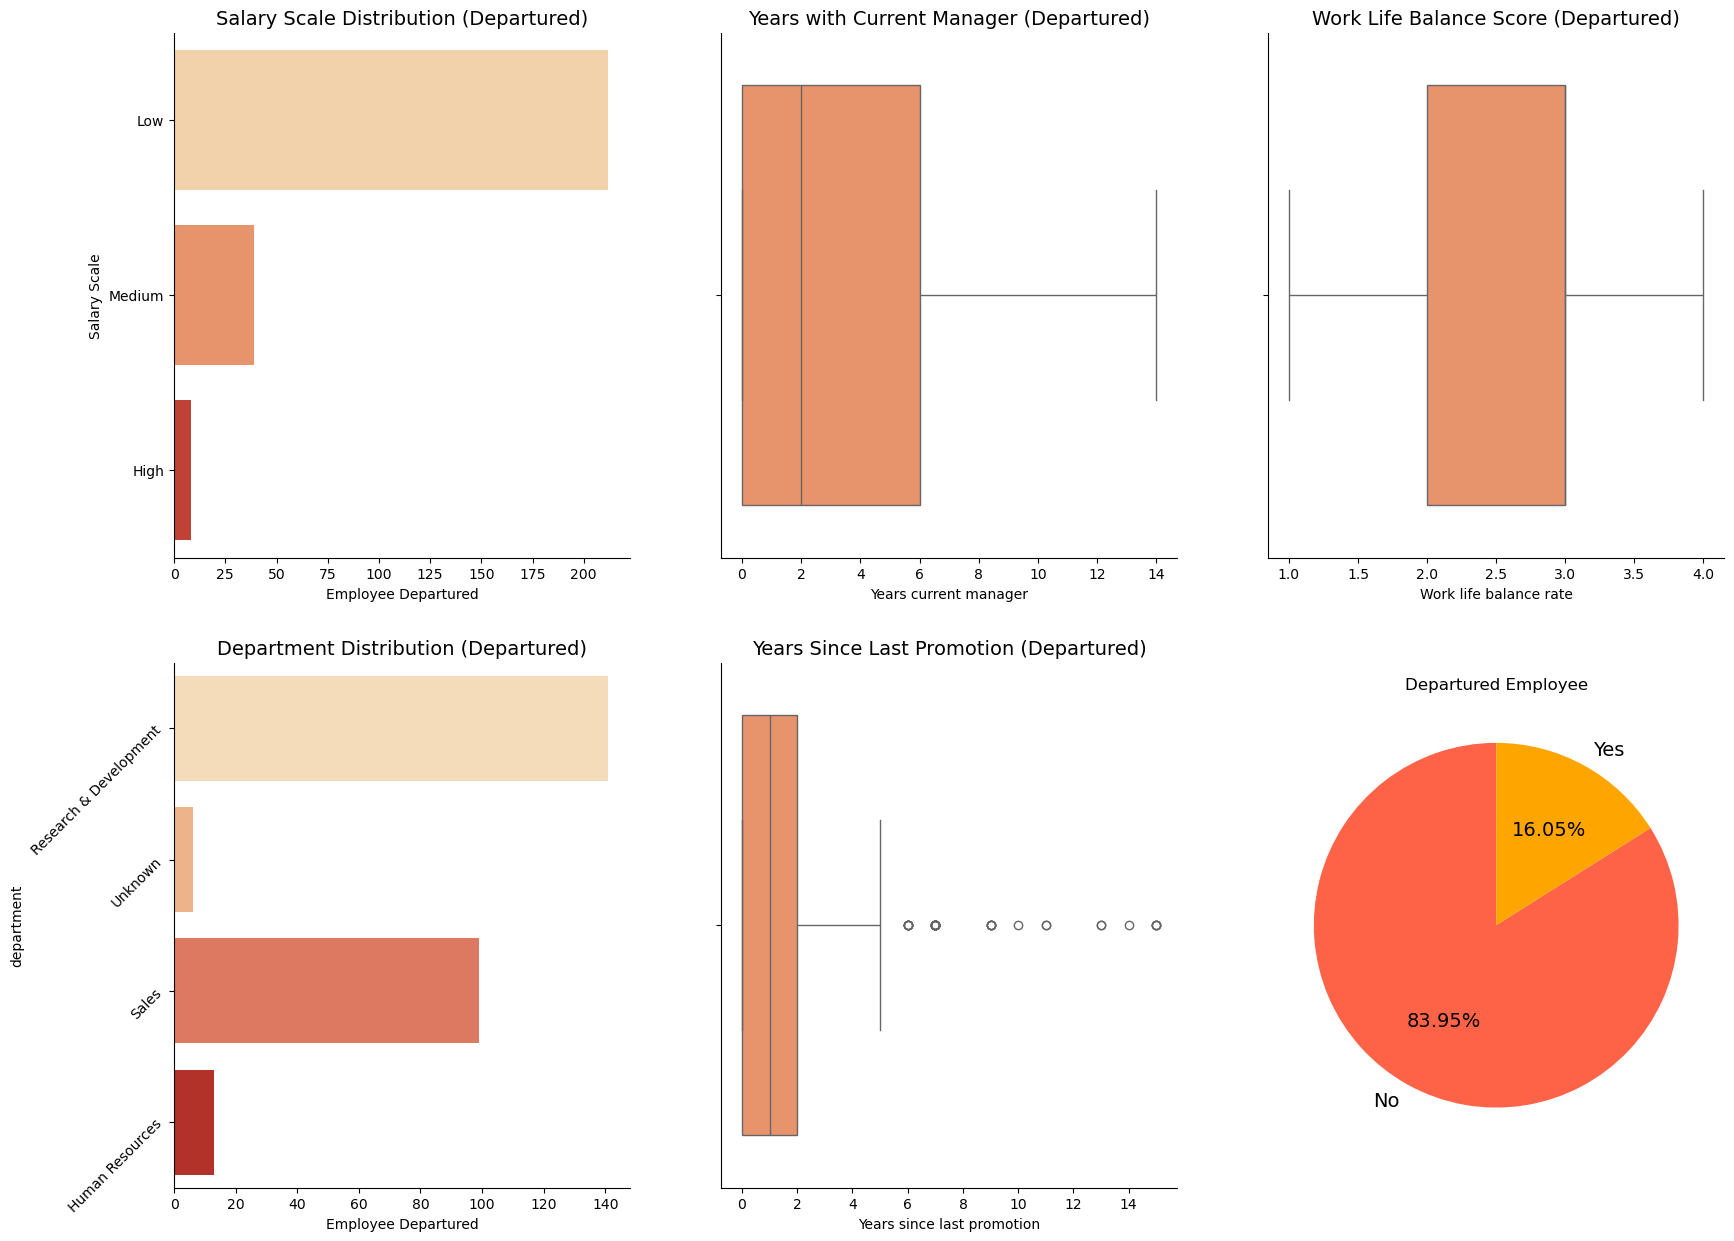

In [36]:

fig, axes = plt.subplots(2, 3, figsize=(20, 15))

sns.countplot(data=yes_df,
              y='salary_scale',
              ax=axes[0, 0],
              palette='OrRd')
axes[0, 0].set_title('Salary Scale Distribution (Departured)', fontsize= 14)
axes[0, 0].set_xlabel('Employee Departured')
axes[0, 0].set_ylabel('Salary Scale')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)


sns.countplot(data=yes_df,
              y='department',
              ax=axes[1, 0],
              palette='OrRd')
axes[1, 0].set_title('Department Distribution (Departured)', fontsize= 14)
axes[1, 0].tick_params(axis='y', rotation=45)
axes[1, 0].set_xlabel('Employee Departured')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)


sns.boxplot(data=yes_df,
            x='year_current_mngr',
            ax=axes[0, 1],
            palette='OrRd'),
axes[0, 1].set_title('Years with Current Manager (Departured)', fontsize= 14)
axes[0, 1].tick_params(axis='y', rotation=45)
axes[0, 1].set_xlabel('Years current manager')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='y', rotation=90)
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)


sns.boxplot(data=yes_df, x='year_last_promotion',
            ax=axes[1, 1],
            palette='OrRd'),
axes[1, 1].set_title('Years Since Last Promotion (Departured)', fontsize= 14)
axes[1, 1].tick_params(axis='y', rotation=90)
axes[1, 1].set_ylabel(' ')
axes[1, 1].set_xlabel('Years since last promotion')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)


sns.boxplot(data=yes_df, x='work_life_balance',
            ax=axes[0, 2],
            palette='OrRd'),
axes[0, 2].set_title('Work Life Balance Score (Departured)', fontsize= 14)
axes[0, 2].set_ylabel('')
axes[0, 2].tick_params(axis='y', rotation=90)
axes[0, 2].set_xlabel('Work life balance rate')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)


plt.pie('employee_number', labels = 'departured', data=df_count_departured, autopct = '%1.2f%%', 
        colors=['tomato', 'orange'], startangle=90, textprops={'fontsize': 14})
axes[1, 2].set_title('Departured Employee');




Interpretación: en esta gráfica observamos solo a los trabajadores que yano trabajan en la empresa. Los empleados con salarios bajos son los que dejan antes la empresa, seguidos por los del departamento de Research and Development. En general duran con su jefe una media de dos años aproximadamente y son promocionados aproximadamente cada año, a excepción de  algunos trabajadores. En general tienen una buena conciliación laboral.

In [37]:
df.head(1)

,employee_number,gender,birth_year,age,marital_status,dist_home,job_title,department,departured,year_at_comp,standard_hours,remote,business_travel,over_time,job_level,stock_opt_level,traning_times_last_year,perf_rate,year_last_promotion,year_current_mngr,education_field,education_scale,annual_salary,monthly_income,daily_rate,perc_salary_hike,env_sat_rate,job_involvement,job_sat_rate,relationship_sat_rate,work_life_balance,num_comp_worked,tot_working_year,salary_scale,dist_home_scale,env_sat_rate_scale,age_scale,current_mngr
0,1,M,1972,51.0,Unknown,6,Research Director,Research & Development,No,20,Full Time,Yes,Unknown,No,5,0,5,3.0,15,15,Unknown,3,195370.0,16280.83,2015.722222,13,1,3,3,3,3.0,7,NaN,High,Near,Low,High,16-20


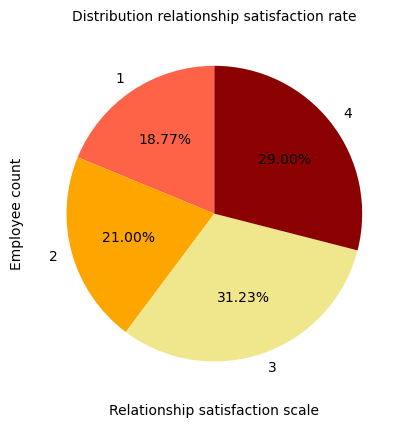

In [38]:
#distribution relationship satisfaction rate
df_relationship_sat_rate = df.groupby('relationship_sat_rate')['employee_number'].count().reset_index()

plt.pie('employee_number', labels = 'relationship_sat_rate', data=df_relationship_sat_rate, autopct = '%1.2f%%', colors=['tomato', 'orange', 'khaki', 'darkred'], startangle=90, textprops={'fontsize': 10});
# Títulos y etiquetas
plt.title('Distribution relationship satisfaction rate', fontsize=10)
plt.xlabel('Relationship satisfaction scale')
plt.ylabel('Employee count');

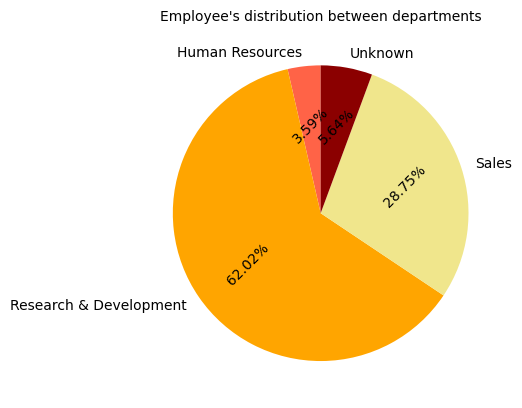

In [39]:
#Distribución de los empleados en función de los departamentos:
df_deparment = df.groupby('department')['employee_number'].count().reset_index()

fig, ax = plt.subplots()

# Crear gráfico de pastel
wedges, texts, autotexts = ax.pie(
    df_deparment['employee_number'],
    labels=df_deparment['department'],
    autopct='%1.2f%%',
    colors=['tomato', 'orange', 'khaki', 'darkred'],
    startangle=90,
    textprops={'fontsize': 10}
)

# Rotar los porcentajes (autotexts)
for autotext in autotexts:
    autotext.set_rotation(45)  # Cambia el ángulo como desees

# Título
ax.set_title("Employee's distribution between departments", fontsize=10);

In [40]:
# Creamos nueva columna de satisfacción total:
df['total_satisfaction'] = df['env_sat_rate'] + df['job_sat_rate'] + df['relationship_sat_rate']

In [41]:
df_sat_total_mean = df.groupby('department')['total_satisfaction'].mean().reset_index()

In [42]:
colors=['tomato', 'orange', 'khaki', 'darkred']

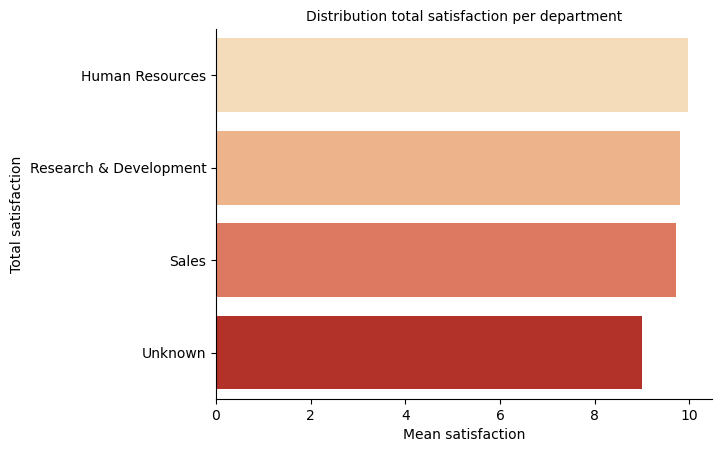

In [43]:
sns.barplot(data=df_sat_total_mean,
              y='department',
              x = 'total_satisfaction',
              palette='OrRd')

plt.title('Distribution total satisfaction per department', fontsize = 10)
plt.xlabel('Mean satisfaction')
plt.ylabel('Total satisfaction');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)